In [1]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [ ]:
mooring_shelfExtended_kogur = xr.open_dataset(r'D:\MScData\mooring_shelfExtended_kogur.nc')
mooring_shelfExtended = xr.open_dataset(r'D:\MScData\mooring_shelfExtended.nc')
mooring_kogur = xr.open_dataset(r'D:\MScData\mooring_kogur.nc')
mooring_north = xr.open_dataset(r'D:\MScData\mooring_north.nc')
depth = xr.open_dataset(r'D:\MScData\Depth_res.nc')['Depth'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth_no_nan = depth
FW_input = xr.open_dataset(r'D:\MScData\oceFWflx.nc')['oceFWflx'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
FW_input2 = xr.open_dataset(r'D:\MScData\SIatmFW.nc')['SIatmFW'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
area = xr.open_dataset(r'D:\MScData\rA.nc')['rA'].sel(Y=slice(65,79)).sel(X=slice(-30,12))
depth = depth.where(depth > 0, np.nan)

TypeError: slice expected at least 1 argument, got 0

Text(0.5, 1.0, 'Masked Data')

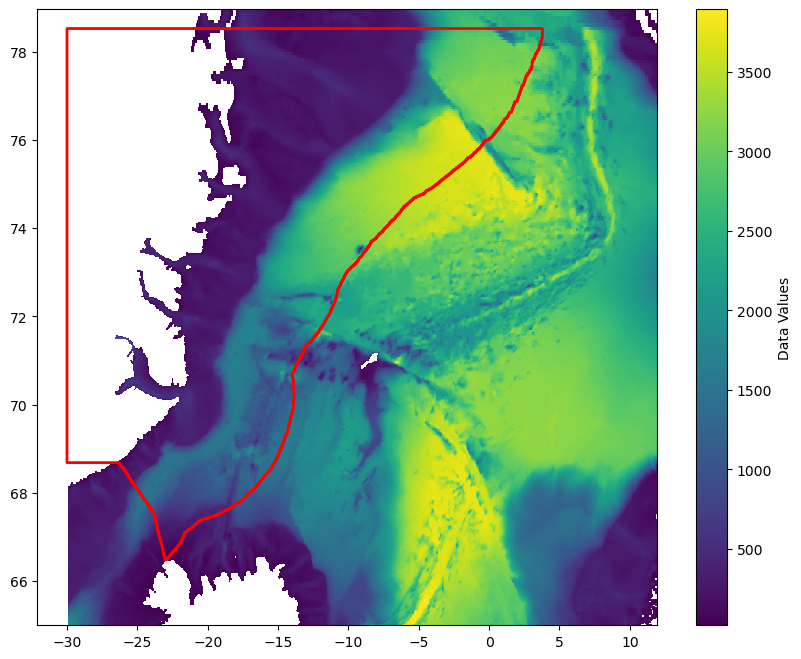

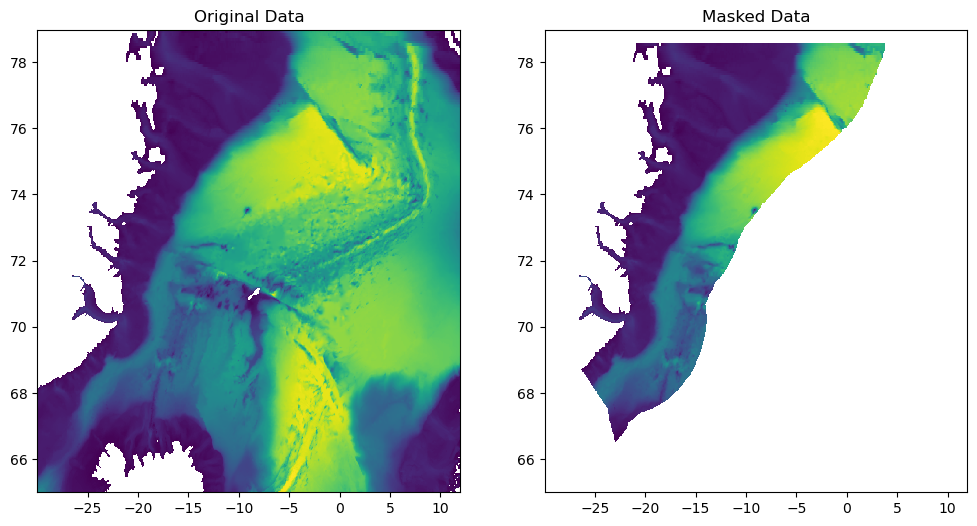

In [20]:
# Domain: (Y=slice(65,79)).sel(X=slice(-30,12))

cond = mooring_north == mooring_north.XC <= 3.788806
mooring_north = mooring_north.where(cond,drop=True)

XC_north = [mooring_north["XC"][x].values[0][0] for x in mooring_north['mooring']]
YC_north = [mooring_north["YC"][x].values[0][0] for x in mooring_north['mooring']]

XC_east1 = [mooring_shelfExtended["XC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
YC_east1 = [mooring_shelfExtended["YC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
XC_east2 = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC_east2 = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]

XC_south = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC_south = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]

# Define western boundary coordinates (example coordinates, replace with actual)
XC_west = [-30] * len(np.linspace(YC_south[0], YC_north[0], 100))  # Replace with actual western boundary X coordinates
YC_west = np.linspace(YC_south[0], YC_north[0], 100)  # Replace with actual western boundary Y coordinates

# Combine boundary coordinates into a single list of tuples
boundary_coords = list(zip(XC_north, YC_north)) + \
                  list(zip(XC_east1, YC_east1)) + \
                  list(zip(XC_east2, YC_east2)) + \
                  list(zip(XC_south[::-1], YC_south[::-1])) + \
                  list(zip(XC_west, YC_west))

data = depth

# Create a Path object from the boundary coordinates
boundary_path = Path(boundary_coords)

# Plot the data and the boundary path
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data
pcm = ax.pcolormesh(data.XC, data.YC, data, shading='auto', cmap='viridis')
fig.colorbar(pcm, ax=ax, label='Data Values')

# Plot the boundary path
boundary_coords.append(boundary_coords[0])  # Close the polygon
boundary_lon, boundary_lat = zip(*boundary_coords)
ax.plot(boundary_lon, boundary_lat, 'r-', linewidth=2, label='Boundary Path')

# Create a mask based on whether points are inside the boundary path
mask = np.zeros(data.shape, dtype=bool)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        point = (data.XC[i, j], data.YC[i, j])
        if not boundary_path.contains_point(point):
            mask[i, j] = True

# Apply the mask to the data
masked_data = np.ma.masked_array(data, mask)

# Plot the original and masked data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax[0].pcolormesh(data.XC, data.YC, data, shading='auto')
ax[0].set_title('Original Data')

# Masked data
ax[1].pcolormesh(data.XC, data.YC, masked_data, shading='auto')
ax[1].set_title('Masked Data')

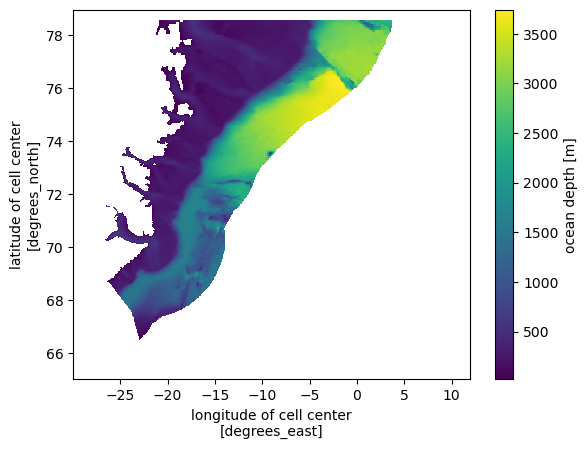

In [24]:
data.where(~mask).plot()

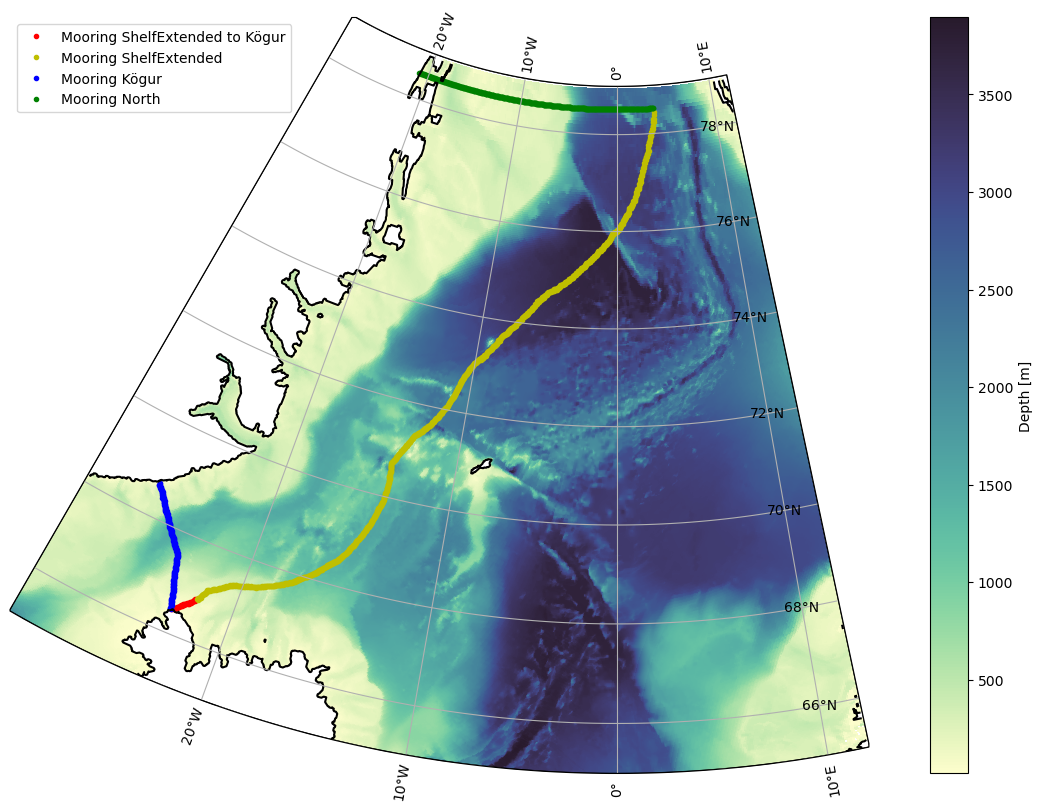

In [25]:
# Plot map and mooring locations
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]

mesh = ax.pcolormesh(depth.X, depth.Y, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('Depth [m]')

XC = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
ax.plot(XC, YC, "r.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended to Kögur')

XC = [mooring_shelfExtended["XC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
YC = [mooring_shelfExtended["YC"][x].values[0][0] for x in mooring_shelfExtended['mooring']]
ax.plot(XC, YC, "y.", transform=ccrs.PlateCarree(), label='Mooring ShelfExtended')

XC = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]
ax.plot(XC, YC, "b.", transform=ccrs.PlateCarree(), label='Mooring Kögur')

XC = [mooring_north["XC"][x].values[0][0] for x in mooring_north['mooring']]
YC = [mooring_north["YC"][x].values[0][0] for x in mooring_north['mooring']]
ax.plot(XC, YC, "g.", transform=ccrs.PlateCarree(), label='Mooring North')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')

In [26]:
display(FW_input)
FW_input = FW_input.mean(dim='time')*area/1000 * 1/1000 # One m^3 is 1000L == 1000kg, thus to convert it into mSv we divide by 1/1000000
FW_input2 = FW_input2.mean(dim='time')*area/1000 * 1/1000

FW_input = FW_input.where(~mask)
FW_input2 = FW_input2.where(~mask)

<xarray.DataArray 'oceFWflx' (time: 1460, Y: 628, X: 765)>
[701413200 values with dtype=float64]
Coordinates:
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 11.62 11.72 11.82 11.92
  * Y        (Y) float64 65.01 65.03 65.04 65.06 ... 78.67 78.75 78.83 78.92
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2017-09-01 ... 2018-08-31T18:00:00
Attributes:
    description:    net surface Fresh-Water flux into the ocean (+=down), >0 ...
    units:          kg/m^2/s
    standard_name:  oceFWflx
    long_name:      net surface Fresh-Water flux into the ocean (+=down), >0 ...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Tot. Amount: 30.15622140803085 mSv')

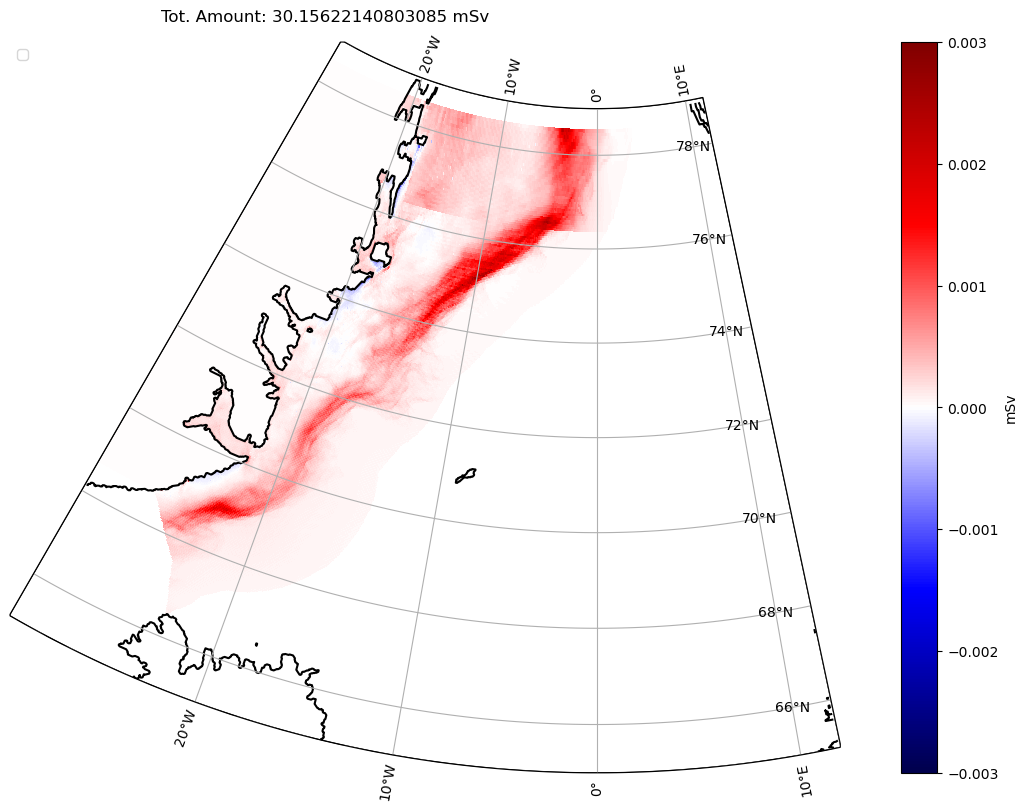

In [27]:
# Plot FW input
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]

mesh = ax.pcolormesh(FW_input.X, FW_input.Y, FW_input, cmap='seismic',vmin=-0.003,vmax=0.003,transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('mSv')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')
fig.suptitle(f'Tot. Amount: {FW_input.sum().values} mSv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Tot. Amount: 10.281131886013211 mSv')

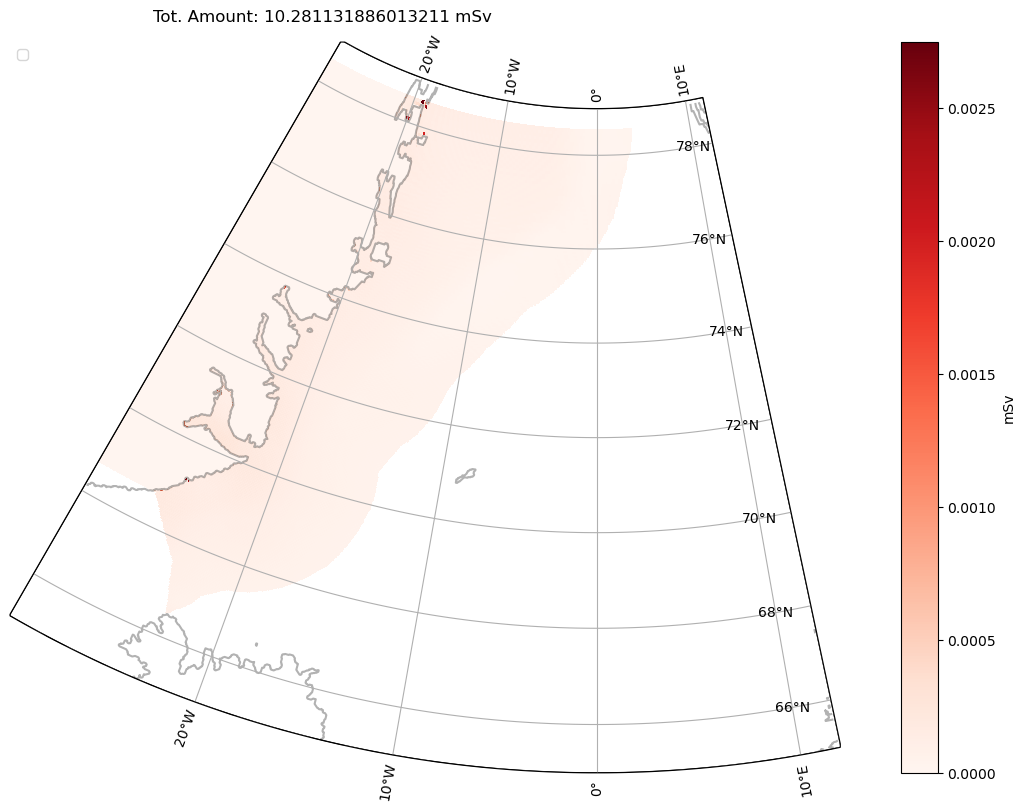

In [28]:
# Plot FW input
fig, ax = plt.subplots(figsize=(14, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()}, layout='constrained') # central_longitude=-10

extent = [-30,12,65,79]

mesh = ax.pcolormesh(FW_input2.X, FW_input2.Y, FW_input2, cmap='Reds',transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh)
cbar.set_label('mSv')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], colors='black', transform=ccrs.PlateCarree(),alpha=0.3)

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines and format them
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.legend(loc='upper left')
fig.suptitle(f'Tot. Amount: {FW_input2.sum().values} mSv')

In [29]:
from FW import FWT
ref_salinity = 34.9

In [30]:
kogur_r = FWT(mooringDataset=mooring_kogur,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [31]:
shelfExtended_r = FWT(mooringDataset=mooring_shelfExtended,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [32]:
shelfExtendedKogur_r = FWT(mooringDataset=mooring_shelfExtended_kogur,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [33]:
north_r = FWT(mooringDataset=mooring_north,ref_salinity=ref_salinity)

Cutting out the oceandataset.


c:\Users\eirik\anaconda3\envs\MSc_Env1\Lib\site-packages\oceanspy\subsample.py:1561: UserWarning: 
Time resampling drops variables on `time_midp` dimension.
Dropped variables: ['time_midp'].
  return cutout(self._od, **kwargs)


Computing horizontal volume transport.


In [34]:
kogur = kogur_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
north = north_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
shelfExtended = shelfExtended_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)
shelfExtendedKogur = shelfExtendedKogur_r.mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0)

In [35]:
display(kogur)

<xarray.DataArray (Z: 216, mooring: 199)>
array([[            nan, -2.50849572e-05, -2.67329044e-05, ...,
        -3.14276982e-07, -3.37462763e-08,             nan],
       [            nan, -3.53963678e-05, -3.73663950e-05, ...,
        -2.24976202e-07,  8.34223119e-08,             nan],
       [            nan, -4.41006751e-05, -4.62844721e-05, ...,
         1.43902846e-07,  2.50627777e-07,             nan],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * Z             (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * mooring       (mooring) int64 0 1 2 3 4 5 6 ... 192 193 194 195 196 197 198
    drF           (Z) float64 2.0 3.0 4.0 5.0 6.0 ... 19.0 19.0 19.0 19.0 19.0
    mooring_dist  (mooring) float64 0.0 1.686 3.371 5.055 ... 378.5 380.2 382.8
    Y             int64 0
    X             int64 0
    XC            (mooring) float64 -26.28 -26.28 -26.28 ... -23.05 -22.99
    YC            (mooring) float64 68.69 68.67 68.66 68.64 ... 66.5 66.48 66.48
    Xind          (mooring) float64 -26.28 -26.28 -26.28 ... -23.05 -22.99
    Yind          (mooring) float64 68.69 68.67 68.66 68.64 ... 66.5 66.48 66.48

In [36]:
# Hist variables
kogur_ = kogur.sum(dim='Z')*1000
kogur_h_p = kogur_.where(kogur_>0)
kogur_h_n = kogur_.where(kogur_<0)

north_ = north.sum(dim='Z')*1000
cond1 = (north_>0) & ((north_.XC <= 3.788806))
cond2 = (north_<0) & ((north_.XC <= 3.788806))
north_h_p = north_.where(cond1)
north_h_n = north_.where(cond2)

shelfExtended_ = shelfExtended.sum(dim='Z')*1000
cond1 = (shelfExtended_>0) & ((shelfExtended_.YC < 74) & (shelfExtended_.YC > 70))
cond2 = (shelfExtended_<0) & ((shelfExtended_.YC < 74) & (shelfExtended_.YC > 70))
shelfExtended_h_p = shelfExtended_.where(cond1)
shelfExtended_h_n = shelfExtended_.where(cond2)

shelfExtendedKogur_ = shelfExtendedKogur.sum(dim='Z')*1000
shelfExtendedKogur_h_p = shelfExtendedKogur_.where(shelfExtendedKogur_>0)
shelfExtendedKogur_h_n = shelfExtendedKogur_.where(shelfExtendedKogur_<0)


In [37]:
display(shelfExtended)

<xarray.DataArray (Z: 216, mooring: 1054)>
array([[            nan,  2.70401948e-05,  1.65783417e-05, ...,
        -1.57740852e-05, -2.59559076e-06,             nan],
       [            nan,  4.28090121e-05,  2.63050077e-05, ...,
        -2.26331838e-05, -3.97235057e-06,             nan],
       [            nan,  5.61631398e-05,  3.46212347e-05, ...,
        -2.80573021e-05, -5.05326828e-06,             nan],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])
Coordinates:
  * Z             (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * mooring       (mooring) int64 0 1 2 3 4 5 ... 1048 1049 1050 1051 1052 1053
    drF           (Z) float64 2.0 3.0 4.0 5.0 6.0 ... 19.0 19.0 19.0 19.0 19.0
    mooring_dist  (mooring) float64 0.0 8.147 16.15 ... 2.158e+03 2.161e+03
    Y             int64 0
    X             int64 0
    XC            (mooring) float64 3.789 3.789 3.789 ... -21.93 -21.93 -21.98
    YC            (mooring) float64 78.45 78.37 78.3 78.3 ... 66.87 66.86 66.86
    Xind          (mooring) float64 3.789 3.789 3.789 ... -21.93 -21.93 -21.98
    Yind          (mooring) float64 78.45 78.37 78.3 78.3 ... 66.87 66.86 66.86

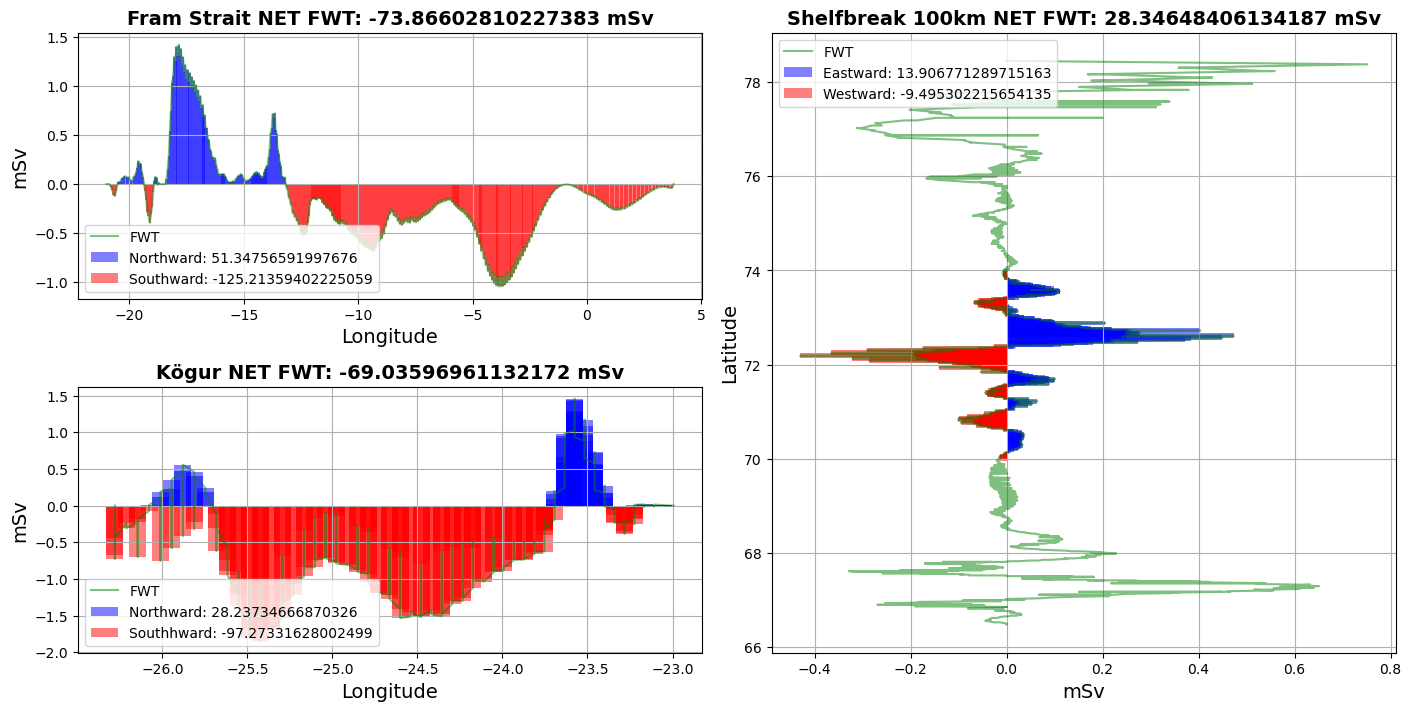

In [59]:
fig, axd = plt.subplot_mosaic([['ul','r'],
                               ['ll','r']],
                               figsize=(14,7), layout='constrained')

axd['ul'].plot(north.XC,north.sum(dim='Z')*1000,color='g',alpha=0.5,label='FWT')
axd['ul'].set_title(f'Fram Strait NET FWT: {north_h_n.sum().values+north_h_p.sum().values} mSv',fontweight='bold',fontsize=14)
axd['ul'].grid()
axd['ul'].bar(north.XC, north_h_p, width=0.1, color='blue', alpha=0.5,label=f'Northward: {north_h_p.sum().values}')
axd['ul'].bar(north.XC, north_h_n, width=0.1, color='red', alpha=0.5,label=f'Southward: {north_h_n.sum().values}')
axd['ul'].set_xlabel('Longitude',fontsize=14)
axd['ul'].set_ylabel('mSv',fontsize=14)
axd['ul'].legend()

axd['ll'].plot(kogur.XC,kogur.sum(dim='Z')*1000,color='g',alpha=0.5,label='FWT')
axd['ll'].set_title(f'Kögur NET FWT: {kogur.sum(dim="Z").sum(dim="mooring").values*1000} mSv',fontweight='bold',fontsize=14)
axd['ll'].grid()
axd['ll'].bar(kogur.XC, kogur_h_p, width=0.1, color='blue', alpha=0.5,label=f'Northward: {kogur_h_p.sum().values}')
axd['ll'].bar(kogur.XC, kogur_h_n, width=0.1, color='red', alpha=0.5,label=f'Southhward: {kogur_h_n.sum().values}')
axd['ll'].set_xlabel('Longitude',fontsize=14)
axd['ll'].set_ylabel('mSv',fontsize=14)
axd['ll'].legend()

axd['r'].plot(shelfExtended.sum(dim='Z')*1000, shelfExtended.YC,color='g',alpha=0.5,label='FWT')
axd['r'].set_title(f'Shelfbreak 100km NET FWT: {shelfExtended.sum(dim="Z").sum(dim="mooring").values*1000 + shelfExtendedKogur.sum(dim="Z").sum(dim="mooring").values*1000} mSv',fontweight='bold',fontsize=14)
axd['r'].barh(shelfExtended.YC, shelfExtended_h_p, height=0.1, color='blue', alpha=0.5, label=f'Eastward: {shelfExtended_h_p.sum().values}')
axd['r'].barh(shelfExtended.YC, shelfExtended_h_n, height=0.1, color='red', alpha=0.5, label=f'Westward: {shelfExtended_h_n.sum().values}')

axd['r'].plot(shelfExtendedKogur.sum(dim='Z')*1000, shelfExtendedKogur.YC,color='g',alpha=0.5)
# axd['r'].barh(shelfExtendedKogur.YC, shelfExtendedKogur_h_p, height=0.1, color='blue', alpha=0.5, label=f'Eastward: {shelfExtendedKogur_h_p.sum().values}')
# axd['r'].barh(shelfExtendedKogur.YC, shelfExtendedKogur_h_n, height=0.1, color='red', alpha=0.5, label=f'Westward: {shelfExtendedKogur_h_n.sum().values}')
axd['r'].set_ylabel('Latitude',fontsize=14)
axd['r'].set_xlabel('mSv',fontsize=14)
axd['r'].grid()
axd['r'].legend()

Text(0.5, 1.0, 'Kögur')

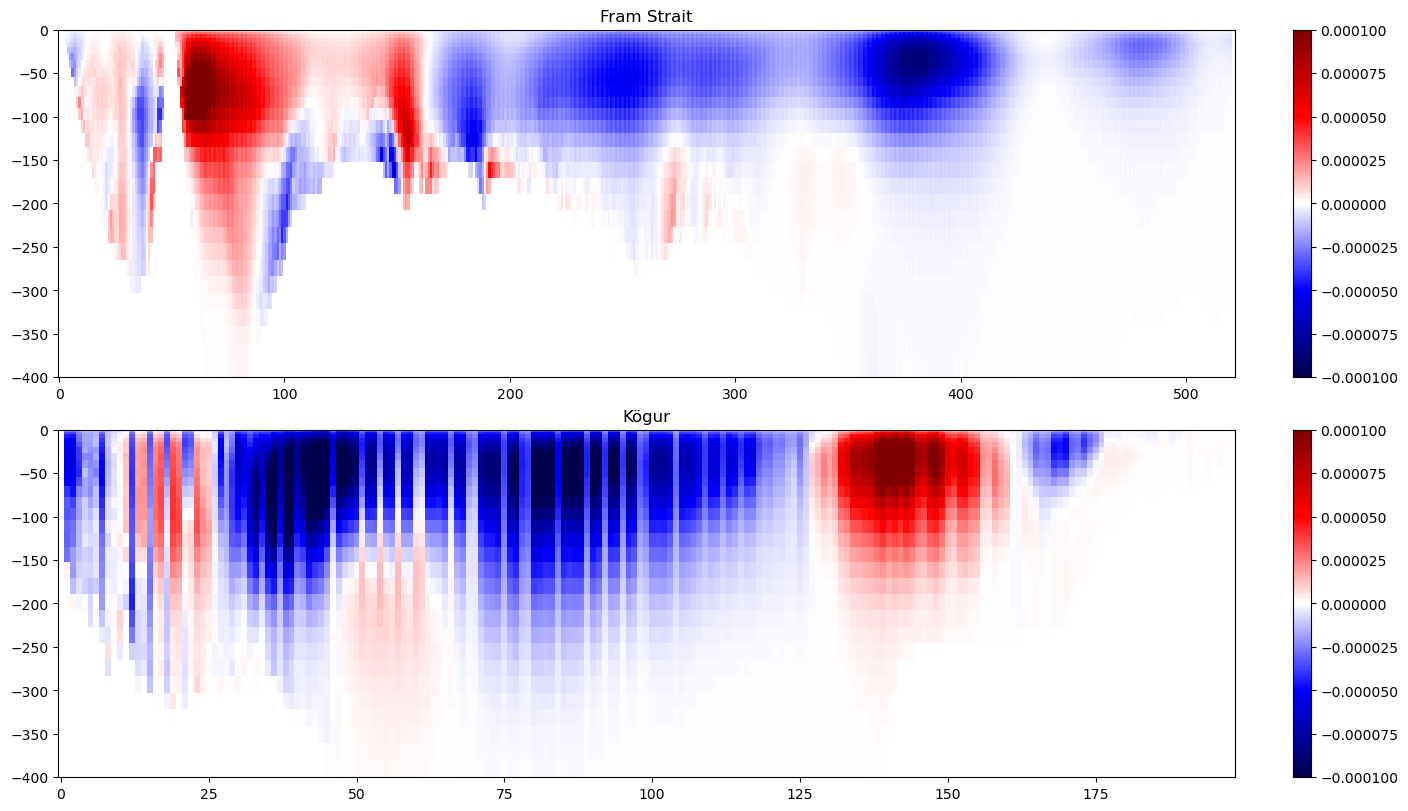

In [39]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(14,8),layout='constrained')
mesh = ax1.pcolormesh(north.mooring,north.Z,north,cmap='seismic',vmin=-0.0001,vmax=0.0001)
cbar = fig.colorbar(mesh)
ax1.set_ylim(-400,0)
ax1.set_title('Fram Strait')

mesh = ax2.pcolormesh(kogur.mooring,kogur.Z,kogur,cmap='seismic',vmin=-0.0001,vmax=0.0001)
cbar = fig.colorbar(mesh)
ax2.set_ylim(-400,0)
ax2.set_title('Kögur')

# Shelfbreak 100km

# Could do
- Shifted correlation of time series of FWT of each transect
- Mask pos/neg numb
- Usikkerhet i referanse salinitet